In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=(0, 90)),
    #transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensor()
])

In [ ]:
torch.manual_seed(42)

train_data = torchvision.datasets.CIFAR10(
    root='CIFAR10/train',
    train=True,
    download=True,
    transform=train_transform,
    #transform=ToTensor()
)

test_data = torchvision.datasets.CIFAR10(
    root='CIFAR10/test',
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_data, test_data

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: CIFAR10/train
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.1)
                RandomVerticalFlip(p=0.1)
                RandomRotation(degrees=[0.0, 90.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: CIFAR10/test
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [ ]:
train_data.classes, len(train_data.classes)

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 10)

(-0.5, 31.5, 31.5, -0.5)

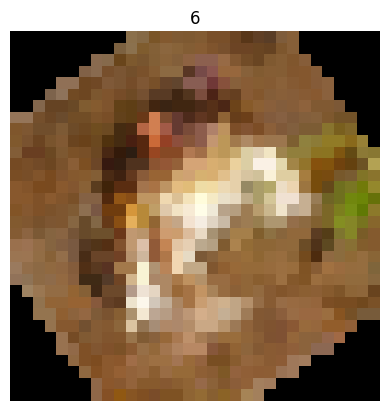

In [ ]:
image, label = train_data[0]

image = image.permute(1, 2, 0)
plt.imshow(image.squeeze())
plt.title(label)
plt.axis("off")

In [ ]:
from torch.utils.data import DataLoader

torch.manual_seed(42)

train_loader = DataLoader(
    dataset=train_data,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_data,
    shuffle=False
)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x787acb9f5f00>,
 <torch.utils.data.dataloader.DataLoader at 0x787acb9f6a70>)

In [ ]:
len(train_loader), len(test_loader)

(782, 10000)

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
# Inception V1.5 Block
class InceptionV1_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool, dimension_reductions: bool=True):
        super().__init__()
        self.branch_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_1x1, kernel_size=1),
            nn.BatchNorm2d(out_1x1),
            nn.ReLU()
        )
        self.branch_2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=red_3x3, kernel_size=1),
            nn.BatchNorm2d(red_3x3),
            nn.ReLU(),
            nn.Conv2d(in_channels=red_3x3, out_channels=out_3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_3x3),
            nn.ReLU()
        )
        self.branch_3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=red_5x5, kernel_size=1),
            nn.BatchNorm2d(red_5x5),
            nn.ReLU(),
            nn.Conv2d(in_channels=red_5x5, out_channels=out_5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU()
        )
        self.branch_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=in_channels, out_channels=out_1x1pool, kernel_size=1),
            nn.BatchNorm2d(out_1x1pool),
            nn.ReLU()
        )

    def forward(self, x):
        first_block_out = self.branch_1(x)
        second_block_out = self.branch_2(x)
        third_block_out = self.branch_3(x)
        fourth_block_out = self.branch_4(x)

        return torch.concat([first_block_out, second_block_out, third_block_out, fourth_block_out], dim=1)

In [ ]:
# Inception V2 Block
class InceptionV2_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool, dimension_reductions: bool=True):
        super().__init__()
        self.branch_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_1x1, kernel_size=1),
            nn.BatchNorm2d(out_1x1),
            nn.ReLU()
        )
        self.branch_2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=red_3x3, kernel_size=1),
            nn.BatchNorm2d(red_3x3),
            nn.ReLU(),
            nn.Conv2d(in_channels=red_3x3, out_channels=out_3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_3x3),
            nn.ReLU()
        )
        self.branch_3 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=red_5x5, kernel_size=1),
            nn.BatchNorm2d(red_5x5),
            nn.ReLU(),
            nn.Conv2d(in_channels=red_5x5, out_channels=out_5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_5x5, out_channels=out_5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_5x5),
            nn.ReLU()
        )
        self.branch_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=in_channels, out_channels=out_1x1pool, kernel_size=1),
            nn.BatchNorm2d(out_1x1pool),
            nn.ReLU()
        )

    def forward(self, x):
        first_block_out = self.branch_1(x)
        second_block_out = self.branch_2(x)
        third_block_out = self.branch_3(x)
        fourth_block_out = self.branch_4(x)

        return torch.concat([first_block_out, second_block_out, third_block_out, fourth_block_out], dim=1)

In [ ]:
# Resnet Block
class ResNet_convert_dim(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

In [ ]:
# Inception V2
class CNN(nn.Module):
    def __init__(self):
        super().__init__() # 3 x 32 x 32
        self.block_1 = nn.Sequential(
            #nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2), # 32 x 32 x 32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 64 x 32 x 32
            #nn.Dropout(0.35),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # 64 x 16 x 16
        )
        self.res_1 = ResNet_convert_dim(3, 64, 2)
        self.block_2 = nn.Sequential(
            #nn.Conv2d(in_channels=32, out_channels=128, kernel_size=5, padding=2), # 128 x 16 x 16
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 128 x 16 x 16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # 256 x 16 x 16
            #nn.Dropout(0.35),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # 256 x 8 x 8
        )
        self.res_2 = ResNet_convert_dim(64, 256, 2) # 128 x 8 x 8
        self.block_3 = nn.Sequential(
            InceptionV2_block(in_channels=256, out_1x1=200, red_3x3=96, out_3x3=100, red_5x5=64, out_5x5=50, out_1x1pool=50), # 400 x 8 x 8
            #nn.Dropout(0.35),
            #nn.MaxPool2d(kernel_size=2), # 240 x 4 x 4
            InceptionV2_block(in_channels=240, out_1x1=256, red_3x3=96, out_3x3=128, red_5x5=64, out_5x5=64, out_1x1pool=32), # 480 x 8 x 8
            nn.MaxPool2d(kernel_size=2) # 480 x 4 x 4
        )
        self.res_3 = ResNet_convert_dim(128, 960, 4)
        self.block_4 = nn.Sequential( # 240 x 4 x 4
            InceptionV2_block(in_channels=480, out_1x1=512, red_3x3=96, out_3x3=256, red_5x5=64, out_5x5=128, out_1x1pool=64), # 960 x 4 x 4
            #nn.Dropout(0.35),
            nn.MaxPool2d(kernel_size=2), # 960 x 2 x 2
            #InceptionV2_block(in_channels=4)
        )
        #self.res_3 = ResNet_convert_dim(128, 960, 4) # 480 x 2 x 2
        self.block_5 = nn.Sequential(
            InceptionV2_block(in_channels=960, out_1x1=512, red_3x3=96, out_3x3=256, red_5x5=64, out_5x5=128, out_1x1pool=64), # 960 x 2 x 2
            nn.Dropout(0.35),
            nn.MaxPool2d(kernel_size=2) # 960 x 1 x 1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # 960 x 1 x 1
            nn.Linear(in_features=960*2*2, out_features=1024),
            nn.Dropout(0.35),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=256),
            nn.Linear(in_features=512, out_features=10)
        )

    def forward(self, x: torch.Tensor): # 3 x 32 x 32
        x_1 = self.block_1(x) + self.res_1(x) # 32 x 16 x 16
        x_2 = self.block_2(x_1) + self.res_2(x_1) # 128 x 8 x 8
        x_3 = self.block_3(x_2) # 240 x 4 x 4
        x_4 = self.block_4(x_3) + self.res_3(x_2) # 960 x 2 x 2
        #x_5 = self.block_5(x_4)
        x_5 = self.classifier(x_4)
        return x_5

In [ ]:
torch.manual_seed(42)

network = CNN().to(device)
network

CNN(
  (block_1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Dropout(p=0.35, inplace=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res_1): ResNet_convert_dim(
    (block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), s

In [ ]:
random_input_image = (1, 3, 32, 32)
random_input_image_error = (1, 3, 250, 250)

summary(CNN(),
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CNN (CNN)                                [1, 3, 32, 32]       [1, 10]              1,152,672            True
├─Sequential (block_1)                   [1, 3, 32, 32]       [1, 32, 16, 16]      --                   True
│    └─Conv2d (0)                        [1, 3, 32, 32]       [1, 3, 32, 32]       84                   True
│    └─BatchNorm2d (1)                   [1, 3, 32, 32]       [1, 3, 32, 32]       6                    True
│    └─ReLU (2)                          [1, 3, 32, 32]       [1, 3, 32, 32]       --                   --
│    └─Conv2d (3)                        [1, 3, 32, 32]       [1, 32, 32, 32]      896                  True
│    └─Dropout (4)                       [1, 32, 32, 32]      [1, 32, 32, 32]      --                   --
│    └─BatchNorm2d (5)                   [1, 32, 32, 32]      [1, 32, 32, 32]      64                   True
│    └─ReLU (6)   

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=network.parameters(),
                            lr=0.001,
                            momentum=0.9,
                            weight_decay=0.01)

from helper_functions import accuracy_fn

In [ ]:
def train_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device):

    list_train_loss, list_train_acc = [], []
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Move X and y to the same device as the model
        X, y = X.to(device), y.to(device)

        # 1. forward pass
        y_pred = model(X)

        # 2. cal loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        # 3. optimizer 0 grad
        optimizer.zero_grad()

        # 4. loss back
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        if (batch + 1) % 100 == 0:
            train_loss_batch = train_loss / (batch + 1)
            train_acc_batch = train_acc / (batch + 1)
            print(f"Train batch: {batch + 1} | Train loss: {train_loss_batch:.5f} | Train acc: {train_acc_batch:.5f}")

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    list_train_loss.append(train_loss)
    list_train_acc.append(train_acc)

    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f}")
    return list_train_loss, list_train_acc

In [ ]:
def test_step(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device):

    list_test_loss, list_test_acc = [], []
    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            # Move X and y to the same device as the model
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))

            if (batch + 1) % 1000 == 0:
                test_loss_batch = test_loss / (batch + 1)
                test_acc_batch = test_acc / (batch + 1)
                print(f"Test batch: {batch + 1} | Test loss: {test_loss_batch:.5f} | Test acc: {test_acc_batch:.5f}")

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        list_test_loss.append(test_loss)
        list_test_acc.append(test_acc)

        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}\n")
    return list_test_loss, list_test_acc

In [ ]:
torch.manual_seed(42)

from tqdm.auto import tqdm

epochs = 100

train_loss, train_acc = [], []
test_loss, test_acc = [], []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")

    train_loss, train_acc = train_step(model=network,
              data_loader=train_loader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)

    test_loss, test_acc = test_step(model=network,
             data_loader=test_loader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
Train batch: 100 | Train loss: 2.21355 | Train acc: 16.71875
Train batch: 200 | Train loss: 2.10580 | Train acc: 21.28125
Train batch: 300 | Train loss: 2.03479 | Train acc: 23.99479
Train batch: 400 | Train loss: 1.97596 | Train acc: 26.21094
Train batch: 500 | Train loss: 1.93821 | Train acc: 27.84062
Train batch: 600 | Train loss: 1.90116 | Train acc: 29.16927
Train batch: 700 | Train loss: 1.86993 | Train acc: 30.39286
Train loss: 1.84445 | Train acc: 31.48178
Test batch: 1000 | Test loss: 2.44434 | Test acc: 17.40000
Test batch: 2000 | Test loss: 2.40577 | Test acc: 18.05000
Test batch: 3000 | Test loss: 2.39678 | Test acc: 18.70000
Test batch: 4000 | Test loss: 2.40898 | Test acc: 18.65000
Test batch: 5000 | Test loss: 2.40879 | Test acc: 18.70000
Test batch: 6000 | Test loss: 2.40731 | Test acc: 18.56667
Test batch: 7000 | Test loss: 2.41018 | Test acc: 18.32857
Test batch: 8000 | Test loss: 2.40732 | Test acc: 18.30000
Test batch: 9000 | Test loss: 2.41201 | Test acc: 

KeyboardInterrupt: 